In [1]:
import ehrapy as ep
import seaborn as sns
import numpy as np
import pandas as pd
import re
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from dowhy import CausalModel
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import graphviz
import networkx as nx 

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)


In [2]:
from drugbankpy import DrugBankConnector
dbc = DrugBankConnector("../drugbank_all_full_database.xml.zip") 

In [3]:
%%time

dbc.find_drug("hydrocortisonesodiumsuccinate", exact=False, fuzzy_threshold=70, return_best=True)

First time using connector, loading drugs...
CPU times: user 20 s, sys: 2.95 s, total: 22.9 s
Wall time: 24 s


,drugbank_id,primary_name,alias_name,type,groups,atc_codes,categories,inchikey,inchi,description,clean_alias_name,fuzzy_score,edit_distance
223728,DB14545,Hydrocortisone succinate,Hydrocortisone succinate,small molecule,approved,,11-Hydroxycorticosteroids|17-Hydroxycorticoste...,VWQWXZAWFPZJDA-CGVGKPPMSA-N,InChI=1S/C25H34O8/c1-23-9-7-15(26)11-14(23)3-4...,,hydrocortisonesuccinate,88,6


In [4]:
drugs = dbc.load_drugs(return_df=True)
drugs.head(3)

,drugbank_id,primary_name,alias_name,type,groups,atc_codes,categories,inchikey,inchi,description
0,DB00001,Lepirudin,Lepirudin,biotech,approved|withdrawn,B01AE02,"Amino Acids, Peptides, and Proteins|Anticoagul...",None,None,Lepirudin is a recombinant hirudin formed by 6...
1,DB00001,Lepirudin,Refludan,biotech,approved|withdrawn,B01AE02,"Amino Acids, Peptides, and Proteins|Anticoagul...",None,None,Lepirudin is a recombinant hirudin formed by 6...
2,DB00002,Cetuximab,Cetuximab,biotech,approved,L01FE01,"Amino Acids, Peptides, and Proteins|Antibodies...",None,None,Cetuximab is a recombinant chimeric human/mous...


In [5]:
def remove_concatenation_symbols(names):
    pattern = r"[\s_\-]"  # Pattern to match whitespaces, underscores, and hyphens
    return "".join(re.split(pattern, names.lower()))


def remove_descriptors(names):
    descriptors = ["ointment", 
                   "Injection", 
                   "for_Injection", 
                   "Oral_Solution", 
                   "inhalation", 
                   "Capsules",
                   "Soft_Capsules",
                   "Drops",
                   "for_Intra_Venous",
                   "Eye_Drops",
                   "Inhalation_Solution",
                   "Tablets",
                   "Injectable_Emulsion",
                   "Cream",
                   "powder"]
    
    # regex to match any of the descriptors
    pattern = r"\b(" + "|".join(re.escape(descriptor) for descriptor in descriptors) + r")\b"
    
    # remove descriptors 
    cleaned_names = re.sub(pattern, "", names, flags=re.IGNORECASE)
    
    return cleaned_names.strip()

drugs["cleaned_names"] = drugs["alias_name"].apply(remove_descriptors)

drugs.cleaned_names

0            Lepirudin
1             Refludan
2            Cetuximab
3              Erbitux
4                     
              ...     
228456         AUM-601
228457         FN-1501
228458    Tinengotinib
228459       Lipotecan
228460    Xenon Xe-129
Name: cleaned_names, Length: 228461, dtype: object

In [6]:
adata = ep.io.read_h5ad("../adata_pneumonia.h5ad")
adata_df = adata.to_df()
adata_df = pd.DataFrame(adata.layers["original_imputed"], columns=adata_df.columns)
obs = pd.DataFrame(adata.obs).reset_index()

adata_df = pd.concat([adata_df, obs], axis=1)
adata_df.columns = adata_df.columns.str.replace(" ", "_")

adata_cols = pd.DataFrame(adata_df.columns, columns=["original"])
adata_cols = adata_cols[~adata_cols["original"].str.contains("ehrapycat|leiden|received|_max|_min")]
adata_cols["unmodified"] = adata_cols["original"]
adata_cols["original"] = adata_cols["original"].str.replace("_avg", "")
adata_cols["cleaned_names"] = adata_cols["original"].apply(remove_concatenation_symbols)
adata_cols["cleaned_names"] = adata_cols["original"].apply(remove_descriptors)
adata_cols

,original,unmodified,cleaned_names
35,LOS,LOS,LOS
38,Eosinophils,Eosinophils_avg,Eosinophils
41,ALB/GLB,ALB/GLB_avg,ALB/GLB
44,adenosine_deaminase,adenosine_deaminase_avg,adenosine_deaminase
47,Albumin,Albumin_avg,Albumin
...,...,...,...
471,ethnicity,ethnicity,ethnicity
472,Death,Death,Death
477,sputum_positive_bacteria,sputum_positive_bacteria,sputum_positive_bacteria
478,sputum_positive_fungi,sputum_positive_fungi,sputum_positive_fungi


In [7]:
%%time

def find_best_match(drug: pd.Series):
    
    try:
        match = dbc.find_drug(drug["cleaned_names"], exact=False, fuzzy_threshold=70, return_best=True)
    except:
        match = None
    
    if match is not None:
        drugbank_id = match["drugbank_id"].values[0]
        alias_name = match["alias_name"].values[0]
        fuzzy_score = match["fuzzy_score"].values[0]
        edit_distance = match["edit_distance"].values[0]
    else:
        drugbank_id = None
        alias_name = None
        fuzzy_score = None
        edit_distance = None
    
    result = pd.DataFrame({
        "original": [drug["original"]],
        "cleaned_names": [drug["cleaned_names"]],
        "alias_name": [alias_name],
        "drugbank_id": [drugbank_id],
        "fuzzy_score": [fuzzy_score],
        "edit_distance": [edit_distance],
    })
        
    return result
    

def worker(element):
    # Worker function for parallel execution
    match = find_best_match(element)
    return match

executor = ThreadPoolExecutor()

best_matches = []
with tqdm(total=len(adata_cols)) as pbar:
    futures = [executor.submit(worker, row) for _, row in adata_cols.iterrows()]
    for future in tqdm(futures):
        match = future.result()
        best_matches.append(match)
        pbar.update(1)

100%|██████████| 297/297 [14:13<00:00,  2.87s/it]

CPU times: user 14min 4s, sys: 24.2 s, total: 14min 29s
Wall time: 14min 13s


In [8]:
col_drug_matches = pd.concat(best_matches)
col_drug_matches.head(3)

,original,cleaned_names,alias_name,drugbank_id,fuzzy_score,edit_distance
0,LOS,LOS,Losec,DB00338,75,2
0,Eosinophils,Eosinophils,Fosinopril,DB00492,76,3
0,ALB/GLB,ALB/GLB,None,None,None,None


## Manually verify the drugs
Compare alias_names to drug names and see if they match.

In [9]:
col_drug_matches.to_csv("./col_drug_matches.csv", index=False, sep=";")

In [18]:
col_drug_matches_verified = pd.read_csv("./col_drug_matches_verified.csv", sep=";")
col_drug_matches_verified.query("match == 1")

,original,cleaned_names,alias_name,drugbank_id,fuzzy_score,edit_distance,match
0,Albumin,Albumin,Albumin (Human),DB00062,100.0,7.0,1
2,"Calcium,_Total","Calcium,_Total",Calcium,DB01373,100.0,7.0,1
3,"Cholesterol,_Total","Cholesterol,_Total",Cholesterol,DB04540,100.0,7.0,1
4,Creatinine,Creatinine,Creatinine,DB11846,100.0,0.0,1
6,Hemoglobin,Hemoglobin,Hemoglobin,DB04945,100.0,0.0,1
...,...,...,...,...,...,...,...
175,Potassium_Chloride_Tablets,Potassium_Chloride_Tablets,Potassium Chloride Injection,DB00761,58.0,10.0,1
179,Hydrocortisone_Sodium_Succinate_For_Injection,Hydrocortisone_Sodium_Succinate_For_Injection,Hydrocortisone Sodium Succinate Injection,DB14545,47.0,7.0,1
182,Desmopressin_Acetate_Tablets,Desmopressin_Acetate_Tablets,Desmopressin Acetate,DB00035,45.0,9.0,1
186,Imipenem_and_Cilastatin_Sodium_for_Injection,Imipenem_and_Cilastatin_Sodium_for_Injection,Imipenem and Cilastatin for Injection,DB01597,39.0,11.0,1


## Count categories of all matches

In [90]:
tmp_drugs = drugs.set_index("alias_name", inplace=False)
tmp_cdmv = col_drug_matches_verified.set_index("alias_name", inplace=False)

tmp = tmp_drugs.join(tmp_cdmv, lsuffix="_x", rsuffix="_y")
tmp = tmp.query("match == 1")
tmp

,drugbank_id_x,primary_name,type,groups,atc_codes,categories,inchikey,inchi,description,cleaned_names_x,clean_alias_name,fuzzy_score_x,original,cleaned_names_y,drugbank_id_y,fuzzy_score_y,edit_distance,match
alias_name,,,,,,,,,,,,,,,,,,
0.9% Sodium Chloride Injection,DB09153,Sodium chloride,small molecule,approved|vet_approved,B05XA03|B05CB01|A12CA01,Alimentary Tract and Metabolism|Blood and Bloo...,FAPWRFPIFSIZLT-UHFFFAOYSA-M,InChI=1S/ClH.Na/h1H;/q;+1/p-1,"Sodium chloride, also known as salt, common sa...",0.9% Sodium Chloride,0.9%sodiumchlorideinjection,33,0.9%_Sodium_Chloride_Injection,0.9%_Sodium_Chloride_Injection,DB09153,95.0,3.0,1.0
Albumin (Human),DB00062,Albumin human,biotech,approved,B05AA01,"Albumins|Amino Acids, Peptides, and Proteins|B...",None,None,Human serum albumin is the primary protein pre...,Albumin (Human),albumin(human),30,Albumin,Albumin,DB00062,100.0,7.0,1.0
Alprostadil Injection USP,DB00770,Alprostadil,small molecule,approved|investigational,C01EA01|G04BE01,Autacoids|Biological Factors|Cardiac Therapy|C...,GMVPRGQOIOIIMI-DWKJAMRDSA-N,InChI=1S/C20H34O5/c1-2-3-6-9-15(21)12-13-17-16...,Alprostadil is produced endogenously and cause...,Alprostadil USP,alprostadilinjectionusp,43,Alprostadil_Injection,Alprostadil_Injection,DB00770,91.0,4.0,1.0
Aminomethylbenzoic acid,DB13244,Aminomethylbenzoic acid,small molecule,experimental,B02AA03,"Amino Acids|Amino Acids, Peptides, and Protein...",QCTBMLYLENLHLA-UHFFFAOYSA-N,InChI=1S/C8H9NO2/c9-5-6-1-3-7(4-2-6)8(10)11/h1...,Aminomethylbenzoic acid may be useful as an an...,Aminomethylbenzoic acid,aminomethylbenzoicacid,44,Aminomethylbenzoic_Acid_Injection,Aminomethylbenzoic_Acid_Injection,DB13244,37.0,11.0,1.0
Amiodarone Hydrochloride Injection,DB01118,Amiodarone,small molecule,approved|investigational,C01BD01,Agents causing hyperkalemia|Agents Causing Mus...,IYIKLHRQXLHMJQ-UHFFFAOYSA-N,InChI=1S/C25H29I2NO3/c1-4-7-11-22-23(18-10-8-9...,"Amiodarone is a benzofuran derivative, anti-ar...",Amiodarone Hydrochloride,amiodaronehydrochlorideinjection,34,Amiodarone_Hydrochloride_injection,Amiodarone_Hydrochloride_injection,DB01118,97.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vancomycin Hydrochloride for Injection USP,DB00512,Vancomycin,small molecule,approved,J01XA01|A07AA09|S01AA28,Agents that produce neuromuscular block (indir...,MYPYJXKWCTUITO-LYRMYLQWSA-N,InChI=1S/C66H75Cl2N9O24/c1-23(2)12-34(71-5)58(...,Antibacterial obtained from Streptomyces orien...,Vancomycin Hydrochloride for USP,vancomycinhydrochlorideforinjectionusp,34,Vancomycin_Hydrochloride_for_Intra_Venous,Vancomycin_Hydrochloride_for_Intra_Venous,DB00512,81.0,11.0,1.0
Vecuronium Bromide for Injection,DB01339,Vecuronium,small molecule,approved|investigational,M03AC03,Androstanes|Androstanols|Anticholinergic Agent...,BGSZAXLLHYERSY-XQIGCQGXSA-N,InChI=1S/C34H57N2O4/c1-23(37)39-31-20-25-12-13...,Monoquaternary homolog of pancuronium. A non-d...,Vecuronium Bromide for,vecuroniumbromideforinjection,32,Vecuronium_Bromide_for_Injection,Vecuronium_Bromide_for_Injection,DB01339,95.0,3.0,1.0
Vitamins A and D Rash,DB11058,Petrolatum,small molecule,approved|investigational,,Basic Ointments and Protectants|Compounds used...,None,None,A colloidal system of semisolid hydrocarbons o...,Vitamins A and D Rash,vitaminsaanddrash,28,Vitamin_A_and_D_Drops,Vitamin_A_and_D_Drops,DB11058,74.0,8.0,1.0


In [101]:
cat_membership = tmp["categories"].str.get_dummies(sep="|")
col_sums = cat_membership.sum(axis=0)

term_counts = pd.DataFrame({"term": cat_membership.columns, "count": col_sums})
term_counts = term_counts.sort_values(by="count", ascending=False)
term_counts.reset_index(drop=True, inplace=True)

term_counts["drugcat"] = ["drugcat_" + term for term in term_counts.term]

term_counts["drugcat"] = (
    term_counts["drugcat"]
    .str.replace(' ', '_')
    .str.replace('(', '')
    .str.replace(')', '')
    .str.replace('-', '_')
)

# Calculate ratios
results = []
featurised = pd.DataFrame()

for term in term_counts.query("count >= 1").term:

    drugnames = cat_membership.query(f"`{term}` == 1").index
    filtered_df = col_drug_matches[col_drug_matches["alias_name"].isin(drugnames)]
    true_colnames = filtered_df.merge(adata_cols, left_on="original", right_on="original", how="left")["unmodified"]
    subset = adata_df[true_colnames]
    pos = (subset > 0).any(axis=1).astype(int).to_frame()
    featurised[term] = pos
    pos_counted = pos.sum()[0]
    neg_counted = len(subset) - pos_counted

    results.append({
        'term': term,
        'pos': pos_counted,
        'neg': neg_counted
    })

results_df = pd.DataFrame(results)
results_df["ratio"] = results_df["pos"] / results_df["neg"]
results_df = pd.merge(results_df, term_counts, left_on="term", right_on="term", how="left")
results_df = results_df.sort_values(by="term", ascending=False)
results_df.sort_values(by="ratio", ascending=False, inplace=True)
results_df
results_df.to_csv("./term_counts_and_ratios.csv", index=False, sep=";")

In [99]:
term_counts

,term,count,drugcat
0,Drugs that are Mainly Renally Excreted,33,drugcat_Drugs_that_are_Mainly_Renally_Excreted
1,Anti-Infective Agents,32,drugcat_Anti_Infective_Agents
2,Antiinfectives for Systemic Use,28,drugcat_Antiinfectives_for_Systemic_Use
3,Cytochrome P-450 Enzyme Inhibitors,27,drugcat_Cytochrome_P_450_Enzyme_Inhibitors
4,Cytochrome P-450 Substrates,25,drugcat_Cytochrome_P_450_Substrates
...,...,...,...
804,Excitatory Amino Acid Antagonists,1,drugcat_Excitatory_Amino_Acid_Antagonists
805,Excitatory Amino Acid Agents,1,drugcat_Excitatory_Amino_Acid_Agents
806,Ethylene Glycols,1,drugcat_Ethylene_Glycols
807,Ethanolamines,1,drugcat_Ethanolamines


In [50]:
term_counts.query("count > 1")[term_counts.query("count > 1").term.str.contains("sep", case=False)]

,term,count
96,BSEP/ABCB11 Substrates,6
102,BSEP/ABCB11 Inhibitors,5
172,BSEP/ABCB11 inducers,4
188,Gynecological Antiinfectives and Antiseptics,3
271,Antiseptics and Disinfectants,2


In [78]:
term_counts.query("count > 4")[["term"]].to_csv("./terms.csv")

{'Drugs that are Mainly Renally Excreted': 'lightgrey', 'Anti-Infective Agents': 'red', 'Antiinfectives for Systemic Use': 'lightgrey', 'Cytochrome P-450 Enzyme Inhibitors': 'lightgrey', 'Cytochrome P-450 Substrates': 'lightgrey', 'Heterocyclic Compounds, Fused-Ring': 'lightgrey', 'Alimentary Tract and Metabolism': 'lightgrey', 'Enzyme Inhibitors': 'lightgrey', 'Antibacterials for Systemic Use': 'lightgrey', 'Sulfur Compounds': 'lightgrey', 'P-glycoprotein inhibitors': 'lightgrey', 'Cytochrome P-450 CYP3A4 Substrates': 'lightgrey', 'Amides': 'lightgrey', 'Cytochrome P-450 CYP3A Substrates': 'lightgrey', 'Anti-Bacterial Agents': 'lightgrey', 'Dermatologicals': 'lightgrey', 'OAT1/SLC22A6 inhibitors': 'lightgrey', 'P-glycoprotein substrates': 'lightgrey', 'Central Nervous System Agents': 'lightgrey', 'Central Nervous System Depressants': 'lightgrey', 'Cytochrome P-450 CYP3A Inhibitors': 'lightgrey', 'Cardiovascular Agents': 'lightgrey', 'Cytochrome P-450 CYP3A4 Inhibitors': 'lightgrey', '

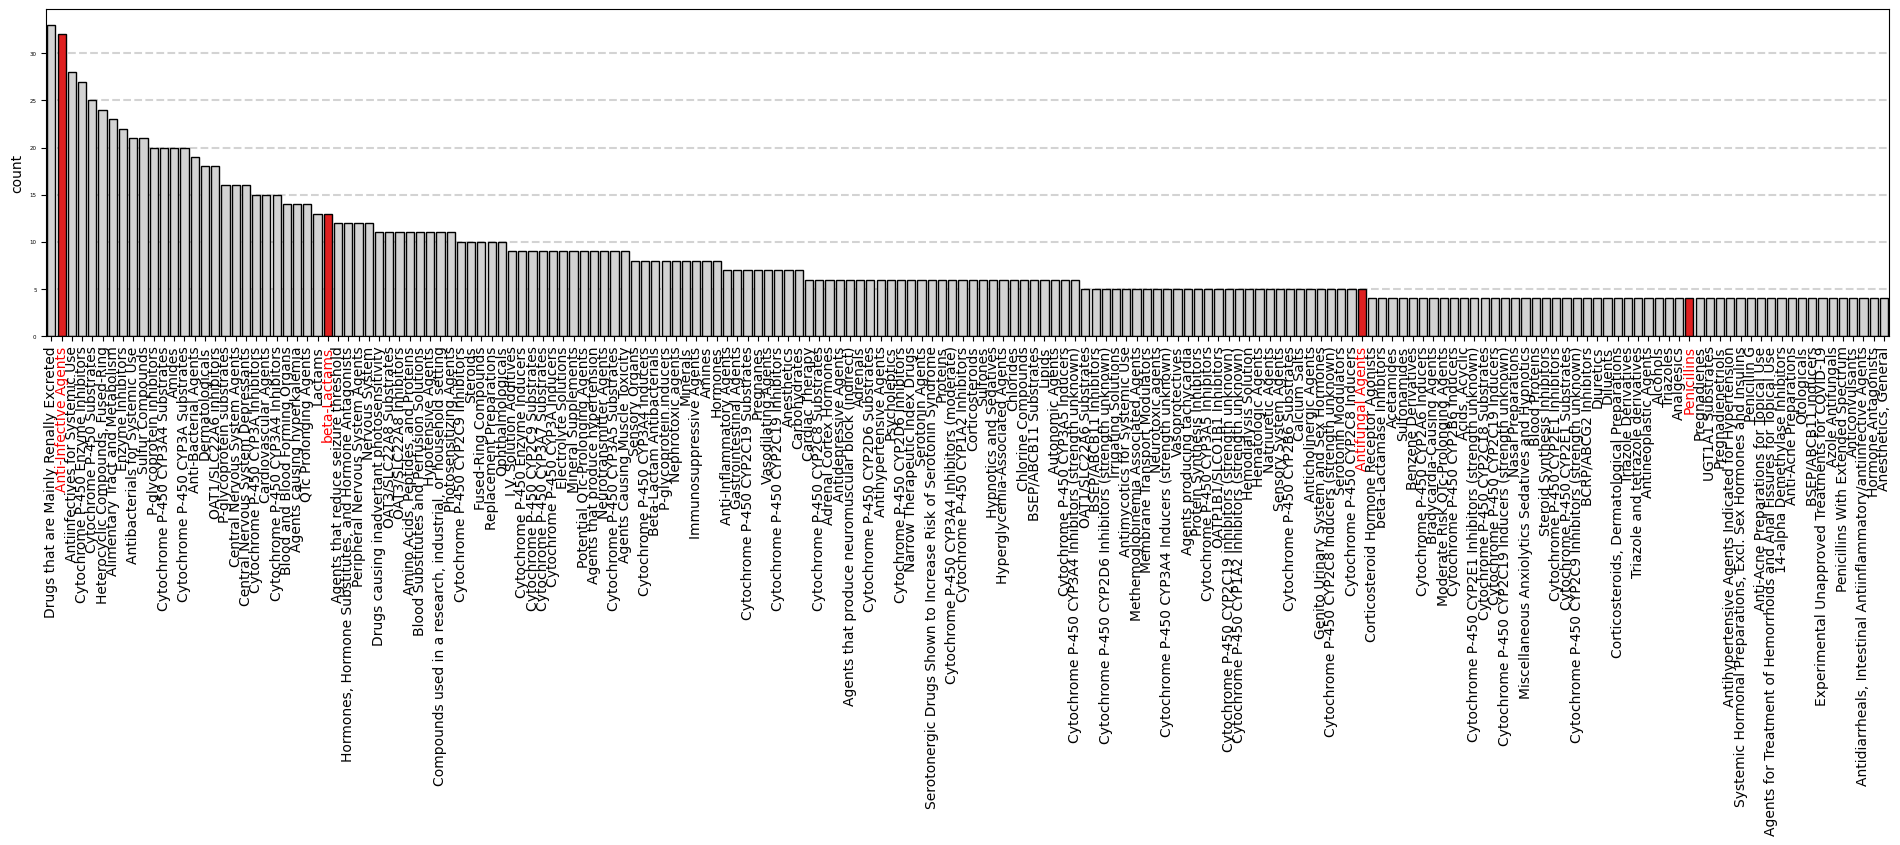

In [88]:
treatments = [
    "Anti-Infective Agents",
    # "drugcat_Carbapenems",
    "beta-Lactams",
    # "drugcat_Antiviral_Agents",
    "Penicillins",
    "Antifungal Agents",
    # "drugcat_Antiseptics_and_Disinfectants"
]

colors = {term: "red" if term in treatments else 'lightgrey' for term in term_counts.query("count >= 4")["term"]}

print(colors)

fig, ax = plt.subplots(1, 1, figsize=(22, 4))
sns.barplot(
    y="count", 
    x="term", 
    data=term_counts.query("count >= 4"), 
    palette=colors,
    edgecolor="black",
    zorder=2,
)

plt.tight_layout()
for i in range(0, 35, 5):
    ax.axhline(i, color="lightgrey", linestyle="--", zorder=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_xlabel("");
ax.tick_params(axis="y", labelsize=4)

for label in ax.get_xticklabels():
    if label.get_text() in treatments:
        label.set_color("red")

In [89]:
results = []
featurised = pd.DataFrame()

for term in term_counts.query("count >= 1").term:

    drugnames = cat_membership.query(f"`{term}` == 1").index
    filtered_df = col_drug_matches[col_drug_matches["alias_name"].isin(drugnames)]
    true_colnames = filtered_df.merge(adata_cols, left_on="original", right_on="original", how="left")["unmodified"]
    subset = adata_df[true_colnames]
    pos = (subset > 0).any(axis=1).astype(int).to_frame()
    featurised[term] = pos
    pos_counted = pos.sum()[0]
    neg_counted = len(subset) - pos_counted

    results.append({
        'term': term,
        'pos': pos_counted,
        'neg': neg_counted
    })

results_df = pd.DataFrame(results)
results_df["ratio"] = results_df["pos"] / results_df["neg"]
results_df = results_df.sort_values(by="term", ascending=False)
results_df

,term,pos,neg,ratio
808,i.v. Solutions,33,244,0.135246
27,beta-Lactams,123,154,0.798701
130,beta-Lactamase Inhibitors,37,240,0.154167
437,"alpha-Galactosidase, antagonists & inhibitors",0,277,0.000000
436,Xanthine derivatives,0,277,0.000000
...,...,...,...,...
131,Acetamides,46,231,0.199134
639,ACE Inhibitors and Diuretics,16,261,0.061303
640,17-Hydroxycorticosteroids,0,277,0.000000
169,14-alpha Demethylase Inhibitors,93,184,0.505435


In [15]:
featurised.columns = featurised.columns.str.replace(" ", "_")
featurised.columns = ["drugcat_" + col for col in featurised.columns]
featurised

,drugcat_Drugs_that_are_Mainly_Renally_Excreted,drugcat_Anti-Infective_Agents,drugcat_Antiinfectives_for_Systemic_Use,drugcat_Cytochrome_P-450_Enzyme_Inhibitors,drugcat_Cytochrome_P-450_Substrates,"drugcat_Heterocyclic_Compounds,_Fused-Ring",drugcat_Alimentary_Tract_and_Metabolism,drugcat_Enzyme_Inhibitors,drugcat_Antibacterials_for_Systemic_Use,drugcat_Sulfur_Compounds,...,"drugcat_Fatty_Acids,_Unsaturated","drugcat_Fatty_Acids,_Monounsaturated",drugcat_Factor_VIII_Activator,drugcat_Explosive_Agents,drugcat_Expectorants,drugcat_Excitatory_Amino_Acid_Antagonists,drugcat_Excitatory_Amino_Acid_Agents,drugcat_Ethylene_Glycols,drugcat_Ethanolamines,drugcat_i.v._Solutions
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,0,1
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,1,1,1,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
273,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,0,1
274,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
275,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


## Append to cohort data

In [16]:
adata = ep.io.read_h5ad("../adata_pneumonia.h5ad")
adata_df = adata.to_df()
adata_df = pd.DataFrame(adata.layers["original_imputed"], columns=adata_df.columns)

obs = pd.DataFrame(adata.obs).reset_index()

adata_df = pd.concat([adata_df, obs, featurised], axis=1)
adata_df.columns = adata_df.columns.str.replace(' ', '_')
adata_df.columns = adata_df.columns.str.replace('(', '')
adata_df.columns = adata_df.columns.str.replace(')', '')
adata_df.columns = adata_df.columns.str.replace('-', '_')

for col in adata_df.columns:
    try:
        adata_df[col] = adata_df[col].astype(float)
    except ValueError:
        del adata_df[col]
    
    
adata_df.to_csv("./adata_pneumonia_drugcats_added.csv", index=False, sep="\t")
adata_df

,ehrapycat_received_rest_0.0,ehrapycat_received_rest_1.0,ehrapycat_sputum_positive_bacteria_0.0,ehrapycat_sputum_positive_bacteria_1.0,ehrapycat_sputum_positive_fungi_0.0,ehrapycat_sputum_positive_fungi_1.0,ehrapycat_ethnicity_Han_ethnic,ehrapycat_ethnicity_Miao_ethnic,ehrapycat_ethnicity_Others,ehrapycat_ethnicity_Tujia_ethnic,...,"drugcat_Fatty_Acids,_Unsaturated","drugcat_Fatty_Acids,_Monounsaturated",drugcat_Factor_VIII_Activator,drugcat_Explosive_Agents,drugcat_Expectorants,drugcat_Excitatory_Amino_Acid_Antagonists,drugcat_Excitatory_Amino_Acid_Agents,drugcat_Ethylene_Glycols,drugcat_Ethanolamines,drugcat_i.v._Solutions
0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
273,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
274,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
275,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
